In [1]:
from __init__ import *

Last updated: Sun Oct 29 2023

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.16.1

Watermark: 2.4.3



In [ ]:
config.experimental.list_physical_devices("GPU")

In [2]:
from sklearn.datasets import make_regression

In [3]:
bias = np.random.randn(8)

In [4]:
x, y, coef = make_regression(
    n_samples=1000,
    n_targets=8,
    bias=0,
    effective_rank=5,
    noise=1.0,
    coef=True,
)
y += bias

In [5]:
f = sm.OLS(y[:, 0], sm.add_constant(x)).fit()

In [6]:
import tensorflow as tf

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.cross_decomposition import PLSRegression

In [8]:
n_pls = 3
pls = PLSRegression(n_components=n_pls)
pls.fit(x, y)

PLSRegression(n_components=3)

In [9]:
na, nb, nc = 50, 30, 20

In [10]:
ridge_penalty = 0.01

In [11]:
enet_init_model = ElasticNet(l1_ratio=0, alpha=ridge_penalty)
enet_init_model.fit(x, y)

ElasticNet(alpha=0.01, l1_ratio=0)

In [12]:
la, lb, lc = 5, 4, 2  # number of cells

In [13]:
pls_inits = []
for ifrom, ito, l in [(0, na, la), (na, na + nb, lb), (na + nb, na + nb + nc, lc)]:
    model = PLSRegression(n_components=l)
    model.fit(x[:, ifrom:ito], y)
    pls_inits.append(model)

In [25]:
class SplitDenseLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        ridge_penalty,
        ridge_init,
        *init_tuples,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self._a = ridge_penalty
        self._init_tuples = init_tuples

    def build(self, input_shape):
        self.ws, self.bs = [], []

        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )

        # Define the bias vector with shape (self.units,)
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        a, b, c = tf.split(
            inputs, num_or_size_splits=(self.na, self.nb, self.nc), axis=0
        )
        output = tf.matmul(inputs, self.w) + self.b

        # Apply the power operation
        return tf.pow(output, self.power)

In [82]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(x.shape[1],)),
        tf.keras.layers.Dense(
            y.shape[1],
            kernel_regularizer=tf.keras.regularizers.l2(1e-2),
            activation="leaky_relu",
        ),
    ]
)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.05)
model.compile(optimizer=optimizer, loss="mse", jit_compile=True)
model.fit(x, y, epochs=100, batch_size=500, steps_per_epoch=2)

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "C:\Users\ppv\PycharmProjects\notes\venv\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ppv\PycharmProjects\notes\venv\lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\ppv\PycharmProjects\notes\venv\lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "C:\Users\ppv\PycharmProjects\notes\venv\lib\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "C:\Users\ppv\PycharmProjects\notes\venv\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: can't apply this __setattr__ to _AnyMeta object
]


Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 3.8256
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 3.6066
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 3.5355
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 3.4903
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 3.4573
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 3.4320
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 3.4116
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 3.3941
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 3.3799
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 3.3678
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 3.3577
Epoch 12/100
2/2 [==============================] - 0s 1ms/step - loss: 3.3489
Epoch 13/100
2/2 [==============================] - 0s 3ms/st

32/32 [==============================] - 0s 2ms/step


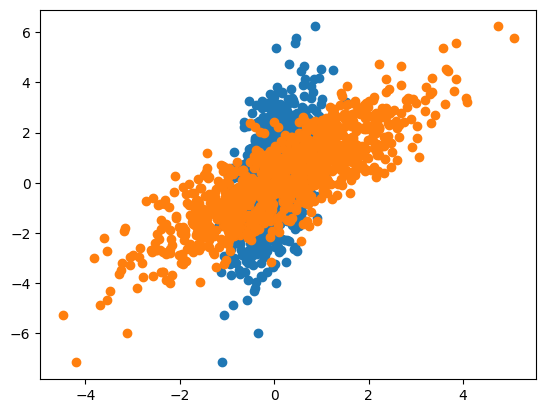

In [80]:
plt.scatter(model.predict(x)[:, 0], y[:, 0])
plt.scatter(f.fittedvalues, y[:, 0])

In [37]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(x.shape[1],)),
        SplitDenseLayer(50, 30, 20),
        tf.keras.layers.Dense(y.shape[1]),
    ]
)

model.set_weights

# Compile the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer="rmsprop", loss="mse", jit_compile=True)

# Train the model for 10 epochs with a batch size of 32
model.fit(x, y, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: 4.3725
Epoch 2/100
32/32 [==============================] - 0s 613us/step - loss: 4.3342
Epoch 3/100
32/32 [==============================] - 0s 613us/step - loss: 4.2963
Epoch 4/100
32/32 [==============================] - 0s 581us/step - loss: 4.2566
Epoch 5/100
32/32 [==============================] - 0s 613us/step - loss: 4.2123
Epoch 6/100
32/32 [==============================] - 0s 710us/step - loss: 4.1648
Epoch 7/100
32/32 [==============================] - 0s 645us/step - loss: 4.1134
Epoch 8/100
32/32 [==============================] - 0s 613us/step - loss: 4.0587
Epoch 9/100
32/32 [==============================] - 0s 613us/step - loss: 4.0005
Epoch 10/100
32/32 [==============================] - 0s 613us/step - loss: 3.9380
Epoch 11/100
32/32 [==============================] - 0s 645us/step - loss: 3.8729
Epoch 12/100
32/32 [==============================] - 0s 581us/step - loss: 3.8070
Epoch 13/100
32

32/32 [==============================] - 0s 871us/step


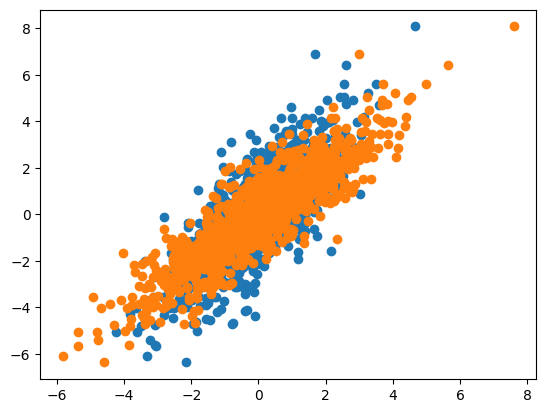

In [38]:
plt.scatter(model.predict(x)[:, 0], y[:, 0])
plt.scatter(f.fittedvalues, y[:, 0])

In [40]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_chec

In [ ]:
plt.scatter(fit.predict(x), y)